# Predicting Gentrification in Austin Neighborhoods - Data Collection and Transformation

**Years Exploring:** 2011-2019 (9 years x 39 obs per year = 351 observations)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import itertools
import matplotlib.pyplot as plt

In [2]:
zips = ('78701', '78702', '78703', '78704', '78705', '78717', '78719','78721',
        '78722', '78723', '78724', '78725', '78726', '78727', '78728', '78729',
        '78730', '78731', '78732', '78733', '78734', '78735', '78736', '78737',
        '78739', '78741', '78742', '78744', '78745', '78746', '78747', '78748',
        '78749', '78750', '78751', '78752', '78753', '78754', '78756', '78757',
        '78758', '78759', '78617', '78653', '78660')

## Import & Merge Data

### Import Census Data

In [3]:
census_vars = pd.read_csv("raw_data/census/census_cleaning - tables.csv")
census_vars['num_subvars'] = census_vars['num_subvars'].astype(int)

In [4]:
#generate list of census variables of interest
def create_var_list(table_name, num_vars, start=1):
  '''
  Creates extension numbers (e.g., _001E,_002E) for variables from the census
  with denomination B0001_001E. 
  '''
  var_lst = []
  for i in range(start,num_vars+1):
    if i<10:
      var_name = table_name + "_00" + str(i) + "E"
    if i>=10:
      var_name = table_name + "_0" + str(i) + "E"
    var_lst.append(var_name)
  return var_lst

all_census_vars = []
for _,row in census_vars.iterrows():
  var = row['table']
  num_vars = row['num_subvars']
  lst = create_var_list(var,num_vars)
  all_census_vars.extend(lst)

In [5]:
def pull_census_var_list(var_lst, year):
  '''
  '''
  vars_as_str = ",".join(var_lst)
  base_url = f'https://api.census.gov/data/{year}/acs/acs5'
  data_url = f'{base_url}?get=NAME,{vars_as_str}&for=zip%20code%20tabulation%20area:*&in=state:{state}&key={api_key}'
  response=requests.get(data_url)
  data=response.json()
  df = pd.DataFrame(data[1:],columns=data[0])
  df = df.set_index('NAME')
  return df

In [6]:
api_key= "cb42edeedb1332cf0293fbc3eecc171b54eeaa11"
state='48'
block_size = 49
census_df = pd.DataFrame()
num_vars = len(all_census_vars)

for year in range(2011, 2020):
  print("year:", year)
  year_df = pd.DataFrame()
  for i, start in enumerate(range(0, num_vars, block_size)):
    #pull 50 vars at a time using API
    print("Main Census Vars Block: ", i+1)
    var_lst = all_census_vars[start:start+block_size]
    df = pull_census_var_list(var_lst, year)
    year_df = pd.concat([year_df, df], axis=1)

  # pull structure vars
  print("Adding Structure Vars")
  if year < 2015: 
    var_lst = create_var_list("B25034",10, 6)
    df = pull_census_var_list(var_lst, year)
    #align var names between time ranges
    df.rename(columns={"B25034_006E":"B25034_007E","B25034_007E":"B25034_008E",
                                "B25034_008E":"B25034_009E","B25034_009E":"B25034_010E",
                                "B25034_010E":"B25034_011E"}, inplace=True)
  else:
    var_lst = create_var_list("B25034",11, 7)
    df = pull_census_var_list(var_lst, year)
  year_df = pd.concat([year_df, df], axis=1)
  year_df["year"] = year

  if census_df.empty:
    census_df = year_df
  else: 
    census_df = pd.concat([census_df, year_df], axis=0)


year: 2011
Main Census Vars Block:  1
Main Census Vars Block:  2
Main Census Vars Block:  3
Main Census Vars Block:  4
Main Census Vars Block:  5
Main Census Vars Block:  6
Adding Structure Vars
year: 2012
Main Census Vars Block:  1
Main Census Vars Block:  2
Main Census Vars Block:  3
Main Census Vars Block:  4
Main Census Vars Block:  5
Main Census Vars Block:  6
Adding Structure Vars
year: 2013
Main Census Vars Block:  1
Main Census Vars Block:  2
Main Census Vars Block:  3
Main Census Vars Block:  4
Main Census Vars Block:  5
Main Census Vars Block:  6
Adding Structure Vars
year: 2014
Main Census Vars Block:  1
Main Census Vars Block:  2
Main Census Vars Block:  3
Main Census Vars Block:  4
Main Census Vars Block:  5
Main Census Vars Block:  6
Adding Structure Vars
year: 2015
Main Census Vars Block:  1
Main Census Vars Block:  2
Main Census Vars Block:  3
Main Census Vars Block:  4
Main Census Vars Block:  5
Main Census Vars Block:  6
Adding Structure Vars
year: 2016
Main Census Va

In [7]:
census_df = census_df.loc[:,~census_df.columns.duplicated()]
census_df.rename(columns={'zip code tabulation area': "zipcode"},
                             inplace=True)
census_df["year"] = census_df["year"].astype(int)

In [8]:
aus_df = census_df[census_df['zipcode'].astype(str).isin(zips)]

#### Name Census Vars

In [9]:
census_vars = pd.read_csv("raw_data/census/census_cleaning - vars.csv")
names = pd.Series(census_vars["New Name"].values, index=census_vars["Name"]).to_dict()

In [10]:
#apply var names
named_df = aus_df
for var in named_df.columns.values: 
  new_name = names.get(var, "")
  if new_name: 
    named_df = named_df.rename(columns={var: new_name})
  elif var[0] == "B":
    named_df = named_df.drop(columns=[var])

In [11]:
clean_df = pd.DataFrame()
for name in ["year", "zipcode"]:
  clean_df[name] = named_df[name]

### Merge Austin Data Portal Data

In [12]:
city_df = pd.read_csv("clean_data/city_portal_data.csv")

In [13]:
city_df['year'] = city_df['year'].astype(int)
city_df['zipcode'] = city_df['zipcode'].astype(str)
clean_df = pd.merge(clean_df, city_df, on = ('year', 'zipcode'), how = 'outer')

## Generate Features

### Census

In [14]:
#Census Data Vars

named_df = named_df.reset_index()

clean_df["Dem: Median Age"] = named_df["P: Median Age"].astype(float)
clean_df["Dem: % <18"] = named_df["P: Total Num <18"].astype(int) / named_df["P: Population"].astype(int)
clean_df["Dem: Pop"] = named_df["P: Population"].astype(int)
clean_df["Div: % NH White"] = named_df["Race: Total Non-Hispanic White"].astype(int) / named_df["Race: Total"].astype(int)
clean_df["Div: % NH Black"] = named_df["Race: Total Non-Hispanic Black"].astype(int) / named_df["Race: Total"].astype(int)
clean_df["Div: % Hispanic"] = named_df["Race: Total Hispanic/Latino"].astype(int) / named_df["Race: Total"].astype(int)
clean_df["Div: % NH Asian"] = named_df["Race: Total Non-Hispanic Asian"].astype(int) / named_df["Race: Total"].astype(int)
clean_df["Div: Max % One Race"] = clean_df[["Div: % NH White", 
                                            "Div: % NH Black", 
                                            "Div: % Hispanic",
                                            "Div: % NH Asian"]].max(axis=1)

clean_df["Div: % Born in US"] = named_df["CZ: Total Born in US"].astype(int) / named_df["CZ: Total"].astype(int)
clean_df["Ed: % Less than HS"] = named_df["E: Total < HS"].astype(int) / named_df["E: Total"].astype(int)
clean_df["Ed: % w/ BA"] = named_df["E: Total BA"].astype(int) / named_df["E: Total"].astype(int)
clean_df["Ed: % w/ Grad"] = named_df["E: Total Grad Degree"].astype(int) / named_df["E: Total"].astype(int)
clean_df["Comp: % Married"] = named_df["M: Total Married (Not Sep)"].astype(int) / named_df["M: Total"].astype(int)
clean_df["Comp: % Fam HHs"] = named_df["HH: Num Family HHs"].astype(int) / named_df["HH: Total HHs"].astype(int)
clean_df["Hsg: Median Gross Rent"] = named_df["R: Median Gross Rent"].astype(float)
clean_df["Hsg: % Paying >20% Income on Housing"] = ((named_df["R: Total [20-25) % on Rent"].astype(int) +
                                                   named_df["R: Total [25-30) % on Rent"].astype(int) +
                                                   named_df["R: Total [30-35) % on Rent"].astype(int) + 
                                                   named_df["R: Total [35-40) % on Rent"].astype(int) +
                                                   named_df["R: Total [40-50) % on Rent"].astype(int) +
                                                   named_df["R: Total 50+ % on Rent"].astype(int))
                                                   / named_df["R: Total"].astype(int))
clean_df["Hsg: % Paying >30% Income on Housing"] = ((named_df["R: Total [30-35) % on Rent"].astype(int) + 
                                                   named_df["R: Total [35-40) % on Rent"].astype(int) +
                                                   named_df["R: Total [40-50) % on Rent"].astype(int) +
                                                   named_df["R: Total 50+ % on Rent"].astype(int))
                                                   / named_df["R: Total"].astype(int))
clean_df["Hsg: % Paying >40% Income on Housing"] = ((named_df["R: Total [40-50) % on Rent"].astype(int) +
                                                   named_df["R: Total 50+ % on Rent"].astype(int))
                                                   / named_df["R: Total"].astype(int))
clean_df["Hsg: % Paying >40% Income on Housing"] = (named_df["R: Total 50+ % on Rent"].astype(int) 
                                                    / named_df["R: Total"].astype(int))
clean_df["Hsg: Median House Val"] = named_df["V: Median Housing Value"].astype(float)
clean_df["Hsg: Median House Costs"] = named_df["V: Median Housing Costs"].astype(float)
clean_df["Inc: Median Income Past 12m"] = named_df["I: Median Income Past 12m"].astype(float)
clean_df["Inc: Income >40K"] = ((named_df["I: Num HHs [40K - 45K)"].astype(int) +
                                named_df["I: Num HHs [45K - 50K)"].astype(int) +
                                named_df["I: Num HHs [50K - 60K)"].astype(int) + 
                                named_df["I: Num HHs [60K - 75K)"].astype(int) +
                                named_df["I: Num HHs [75K - 100K)"].astype(int) +
                                named_df["I: Num HHs [100K - 125K)"].astype(int) +
                                named_df["I: Num HHs [125K - 150K)"].astype(int) +
                                named_df["I: Num HHs [150K - 200K)"].astype(int) +
                                named_df["I: Num HHs 200K+"].astype(int))
                                / named_df["I: Total HHs"].astype(int))
clean_df["Inc: Income >60K"] = ((named_df["I: Num HHs [60K - 75K)"].astype(int) +
                                named_df["I: Num HHs [75K - 100K)"].astype(int) +
                                named_df["I: Num HHs [100K - 125K)"].astype(int) +
                                named_df["I: Num HHs [125K - 150K)"].astype(int) +
                                named_df["I: Num HHs [150K - 200K)"].astype(int) +
                                named_df["I: Num HHs 200K+"].astype(int))
                                / named_df["I: Total HHs"].astype(int))
clean_df["Inc: Income >100K"] = ((named_df["I: Num HHs [100K - 125K)"].astype(int) +
                                named_df["I: Num HHs [125K - 150K)"].astype(int) +
                                named_df["I: Num HHs [150K - 200K)"].astype(int) +
                                named_df["I: Num HHs 200K+"].astype(int))
                                / named_df["I: Total HHs"].astype(int))
clean_df["Inc: PC Income"] = named_df["I: Per Capita Income"].astype(float)
clean_df["Inc: Gini Index"] = named_df["I: Gini Index"].astype(float)
clean_df["Mob: % Same House (1y)"] = (named_df["G1yr: Total in Same House"].astype(int) 
                                     / named_df["G1yr: Total"].astype(int))
clean_df["Mob: % From Out of State (1y)"] = ((named_df["G1yr: Total from Diff State"].astype(int) +
                                            named_df["G1yr: Total from Abroad"].astype(int)) 
                                            / named_df["G1yr: Total"].astype(int))
clean_df["Occ: % in Labor Force"] = (named_df["L: Total in Labor Force"].astype(int) 
                                    / named_df["L: Total"].astype(int))
clean_df["Occ: % in mgmt/bus/science/arts"] = (named_df["O: Total in Mgmt/Bus/Science/Arts"].astype(int)
                                              / named_df["O: Total"].astype(int))
clean_df["Occ: % in serv/construct/prod"] = ((named_df["O: Total in Services"].astype(int) +
                                            named_df["O: Total in NatRes/Construct/Maint"].astype(int) +
                                            named_df["O: Total in Production/Transport/Materials"].astype(int))
                                            / named_df["O: Total"].astype(int))
clean_df["Trns: % w/ 3+ Vehicles"]  = ((named_df["Veh: Total w/ 3 Cars"].astype(int) +
                                      named_df["Veh: Total w/ 4 Cars"].astype(int) +
                                      named_df["Veh: Total w/ 5 Cars"].astype(int))
                                      / named_df["Veh: Total"].astype(int))
clean_df["Trns: % Walk/Bike to Work"] = ((named_df["T: Total Bike to Work"].astype(int) + 
                                          named_df["T: Total Walk to Work"].astype(int))
                                        / named_df["T: Total"].astype(int))
clean_df["Trns: % Public Trans to Work"] = (named_df["T: Total Public Trans to Work"].astype(int)
                                          / named_df["T: Total"].astype(int))
clean_df["Hsg: % Owner Occupied"] = (named_df["H: Total Owner Occupied"].astype(int) 
                                    / named_df["H: Total"].astype(int))
clean_df["Hsg: % Renter Occupied"] = (named_df["H: Total Renter Occupied"].astype(int)
                                     / named_df["H: Total"].astype(int))
clean_df["Unt: % w/ 1"] = ((named_df["Units: Num w/ 1 detached"].astype(int) + 
                            named_df["Units: Num w/ 1 attached"].astype(int)) 
                          / named_df["Units: Total"].astype(int))
clean_df["Unt: % w/ 5+"] = ((named_df["Units: Num w/ 5-9"].astype(int) + 
                            named_df["Units: Num w/ 10-19"].astype(int) +
                            named_df["Units: Num w/ 20-49"].astype(int) +
                            named_df["Units: Num w/ 50+"].astype(int)) 
                          / named_df["Units: Total"].astype(int))
clean_df["Unt: % w/ 50+"] = (named_df["Units: Num w/ 50+"].astype(int)
                          / named_df["Units: Total"].astype(int))
clean_df["Unt: % w/ 3+bdrm"] = ((named_df["B: Total 3 Bdrms"].astype(int) + 
                            named_df["B: Total 4 Bdrms"].astype(int) +
                            named_df["B: Total 5+ Bdrms"].astype(int)) 
                            / named_df["B: Total"].astype(int))
clean_df["Unt: % w/ 1bdrm"] = (named_df["B: Total 1 Bdrm"].astype(int)
                            / named_df["B: Total"].astype(int))

clean_df["Y: % built pre-1970"] = ((named_df["Y: Total Built 1960-1969"].astype(int) +
                            named_df["Y: Total Built 1950-1959"].astype(int) +
                            named_df["Y: Total Built 1940-1949"].astype(int) + 
                            named_df["Y: Total Built Pre-1940"].astype(int))
                          / named_df["Units: Total"].astype(int))
clean_df["Y: % built pre-1940"] = (named_df["Y: Total Built Pre-1940"].astype(int)
                                  / named_df["Units: Total"].astype(int))
clean_df["Y: median yr built"] = named_df["Y: Median Year Structure Built"].astype(int)

### Austin Data Portal

In [16]:
per_cap_vars = ['com_permit_count', 'res_permit_count',
                'count_assault_crime', 'count_criminal_activity_crime',
                'count_identity_theft_crime', 'count_narcotics_crime',
                'count_public_intoxication_crime', 'count_runaway_child_crime',
                'count_theft_crime', 'count_warrent_arrest_crime']

for var in per_cap_vars:
  name = var.replace("count_", "")
  name = name.replace("_count", "") + '_per_cap'
  clean_df[name] = clean_df[var].astype(float) / clean_df['Dem: Pop'].astype(float)
  clean_df.drop(columns = [var], inplace = True)

clean_df['Dem: Pop Density'] = clean_df['Dem: Pop'].astype(float) / clean_df['sq_mile_area'].astype(float)
clean_df.drop(columns = ['sq_mile_area'], inplace = True)

## Generate Classifiers

In [19]:
clean_df["Hsg: Median Gross Rent"] = named_df["R: Median Gross Rent"] 
clean_df["Inc: Median Income Past 12m"] = named_df["I: Median Income Past 12m"]
clean_df["Ed: % w/ BA"] = named_df["E: Total BA"].astype(int) / named_df["E: Total"].astype(int)
clean_df["Hsg: Median House Val"] = named_df["V: Median Housing Value"]

In [20]:
#next year
next_year = clean_df[["year", "zipcode", "Inc: Median Income Past 12m", 
                                        "Ed: % w/ BA", 
                                        "Hsg: Median Gross Rent", 
                                        "Hsg: Median House Val"]]
next_year = next_year.rename(columns={"year":"1 year"})

for name in ["Inc: Median Income Past 12m", "Ed: % w/ BA", "Hsg: Median Gross Rent", "Hsg: Median House Val"]:
  next_year = next_year.rename(columns={name: "1Y: " + name})

#five years
five_years = clean_df[["year", "zipcode", "Inc: Median Income Past 12m", 
                                        "Ed: % w/ BA", 
                                        "Hsg: Median Gross Rent", 
                                        "Hsg: Median House Val"]]
five_years = five_years.rename(columns={"year":"5 years"})

for name in ["Inc: Median Income Past 12m", "Ed: % w/ BA", "Hsg: Median Gross Rent", "Hsg: Median House Val"]:
  five_years = five_years.rename(columns={name: "5Y: " + name})

In [21]:
clean_df.insert(1, "1 year", clean_df["year"] + 1)
clean_df.insert(2, "5 years", clean_df["year"] + 5)

In [22]:
#1 year out
df = clean_df.merge(next_year, how='left', on=["zipcode", "1 year"])
df["year"] = df["year"].astype(int)
#df = df[df["year"] <= 2018]

#5 years out
df = df.merge(five_years, how='left', on=["zipcode", "5 years"])
df["year"] = df["year"].astype(int)
#df = df[df["year"] <= 2014]
df.head()

,year,1 year,5 years,zipcode,Dem: Median Age,Dem: % <18,Dem: Pop,Div: % NH White,Div: % Black,Div: % Latino,...,warrent_arrest_crime_per_cap,Dem: Pop Density,1Y: Inc: Median Income Past 12m,1Y: Ed: % w/ BA,1Y: Hsg: Median Gross Rent,1Y: Hsg: Median House Val,5Y: Inc: Median Income Past 12m,5Y: Ed: % w/ BA,5Y: Hsg: Median Gross Rent,5Y: Hsg: Median House Val
0,2011,2012,2016,78730,37.2,0.256491,8242,0.822980,0.025722,0.949648,...,0.000121,446.271975,48353,0.409150,1106,570400,54362,0.403878,1219,641200
1,2011,2012,2016,78733,39.3,0.324005,9219,0.889901,0.002929,0.887406,...,0.000000,570.453883,55855,0.338661,1496,467700,52926,0.407375,1608,528100
2,2011,2012,2016,78751,28.0,0.105466,14526,0.829134,0.017348,0.870302,...,0.014319,4151.785002,24546,0.363252,865,292200,31480,0.424192,1087,366100
3,2011,2012,2016,78701,33.1,0.011212,5084,0.805862,0.078088,0.880409,...,0.141424,2214.972616,49099,0.385511,1590,338300,76111,0.399239,1734,447100
4,2011,2012,2016,78735,35.6,0.233275,16024,0.858213,0.007177,0.817524,...,0.001747,631.385646,43903,0.424783,1122,379900,50853,0.381499,1304,426500


In [23]:
'''
Create binary outcome var
1. Change in median HH income - Austin median change in median HH income > 0.10 
2. Change in % college educated - Austin median change in % college educated > 0.10 
3. Change in median gross rent - Austin median change in median gross rent > 0.10 
   Change in median home value - Austin median change in median home value > 0.10 
'''

vars = ["Inc: Median Income Past 12m",
        "Ed: % w/ BA",
        "Hsg: Median Gross Rent",
        "Hsg: Median House Val"]

for var in vars: 
  df["1Y CHG: " + var] = df["1Y: " + var].astype(float) - df[var].astype(float)
  df["5Y CHG: " + var] = df["5Y: " + var].astype(float) - df[var].astype(float)

  df["1Y CHG > Median " + var] = df["1Y CHG: " + var] > df["1Y CHG: " + var].median()
  df["5Y CHG > Median " + var] = df["5Y CHG: " + var] > df["5Y CHG: " + var].median()
  df["1Y CHG > 75th " + var] = df["1Y CHG: " + var] > df["1Y CHG: " + var].quantile(.75)
  df["5Y CHG > 75th " + var] = df["5Y CHG: " + var] > df["5Y CHG: " + var].quantile(.75)

for time in ["1Y", "5Y"]:
  df["Gentrified " + time + " Median"] = (df[time + " CHG > Median Inc: Median Income Past 12m"] &
                                          df[time + " CHG > Median Ed: % w/ BA"] &
                                          (df[time + " CHG > Median Hsg: Median Gross Rent"] |
                                          df[time + " CHG > Median Hsg: Median House Val"]))
  df["Gentrified " + time + " 75th"] = (df[time + " CHG > 75th Inc: Median Income Past 12m"] &
                                        df[time + " CHG > 75th Ed: % w/ BA"] &
                                        (df[time + " CHG > 75th Hsg: Median Gross Rent"] |
                                        df[time + " CHG > 75th Hsg: Median House Val"]))

In [24]:
df.drop(columns = ["Inc: Median Income Past 12m",
        "Ed: % w/ BA",
        "Hsg: Median Gross Rent",
        "Hsg: Median House Val"], inplace=True)

In [25]:
# SUMMARY STATS TO SHOW WHY WE DROP 75TH PERCENTILE CUTOFF!!
df.describe()

,year,1 year,5 years,Dem: Median Age,Dem: % <18,Dem: Pop,Div: % NH White,Div: % Black,Div: % Latino,Div: % Born in US,...,1Y: Ed: % w/ BA,5Y: Ed: % w/ BA,1Y CHG: Inc: Median Income Past 12m,5Y CHG: Inc: Median Income Past 12m,1Y CHG: Ed: % w/ BA,5Y CHG: Ed: % w/ BA,1Y CHG: Hsg: Median Gross Rent,5Y CHG: Hsg: Median Gross Rent,1Y CHG: Hsg: Median House Val,5Y CHG: Hsg: Median House Val
count,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,405.000000,...,360.000000,180.000000,342.000000,180.000000,360.000000,180.000000,360.000000,180.000000,3.600000e+02,1.800000e+02
mean,2015.000000,2016.000000,2020.000000,34.551358,0.229514,25134.639506,0.740057,0.081408,0.685462,0.831851,...,0.301316,0.312054,1267.029240,6359.050000,0.004952,0.025422,47.697222,240.605556,-1.836403e+06,-3.624005e+06
std,2.585182,2.585182,2.585182,4.892152,0.074478,16594.623785,0.131089,0.080375,0.206782,0.072468,...,0.117538,0.119016,1935.020449,5364.922042,0.015849,0.036364,88.563654,152.156619,3.514032e+07,4.970273e+07
min,2011.000000,2012.000000,2016.000000,20.800000,0.011212,517.000000,0.342308,0.000000,0.168520,0.614917,...,0.042945,0.042945,-4703.000000,-9184.000000,-0.086905,-0.071750,-746.000000,-340.000000,-6.667250e+08,-6.667512e+08
25%,2013.000000,2014.000000,2018.000000,31.600000,0.188402,13570.000000,0.647512,0.022033,0.516450,0.800551,...,0.220466,0.235475,210.000000,3099.500000,-0.003674,0.001122,21.000000,176.500000,4.975000e+03,4.182500e+04
50%,2015.000000,2016.000000,2020.000000,34.100000,0.231543,21125.000000,0.769380,0.049449,0.786643,0.854562,...,0.339873,0.352534,1081.500000,5786.000000,0.005052,0.021322,41.500000,226.500000,1.335000e+04,7.640000e+04
75%,2017.000000,2018.000000,2022.000000,37.800000,0.278851,31734.000000,0.846063,0.120175,0.857323,0.882158,...,0.396510,0.408965,2217.750000,8791.500000,0.014025,0.049418,68.000000,294.250000,2.392500e+04,1.088500e+05
max,2019.000000,2020.000000,2024.000000,46.500000,0.373518,91300.000000,0.939388,0.405807,0.949648,0.944099,...,0.491055,0.491055,10887.000000,36202.000000,0.064530,0.127959,670.000000,1027.000000,6.510000e+04,2.373000e+05


In [26]:
# Summary stats to show no missing values!!
features_all = df[df.columns[5:-36]]
outcomes = df[df.columns[-36:]]

## Generate Multipe Feature Sets

*   Check multicolinearity between features
*   Have full set of features, medium set of features, and small set of features (based on different correlation cut-offs)

In [27]:
# Create correlation matrix
corr_matrix = features_all.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop_s = [column for column in upper.columns if any(abs(upper[column]) > 0.75)]
to_drop_m = [column for column in upper.columns if any(abs(upper[column]) > 0.85)]

# Drop features 
df_s = df.drop(to_drop_s, axis=1)
features_s = features_all.drop(to_drop_s, axis=1)

# Drop features 
df_m = df.drop(to_drop_m, axis=1)
features_m = features_all.drop(to_drop_m, axis=1)

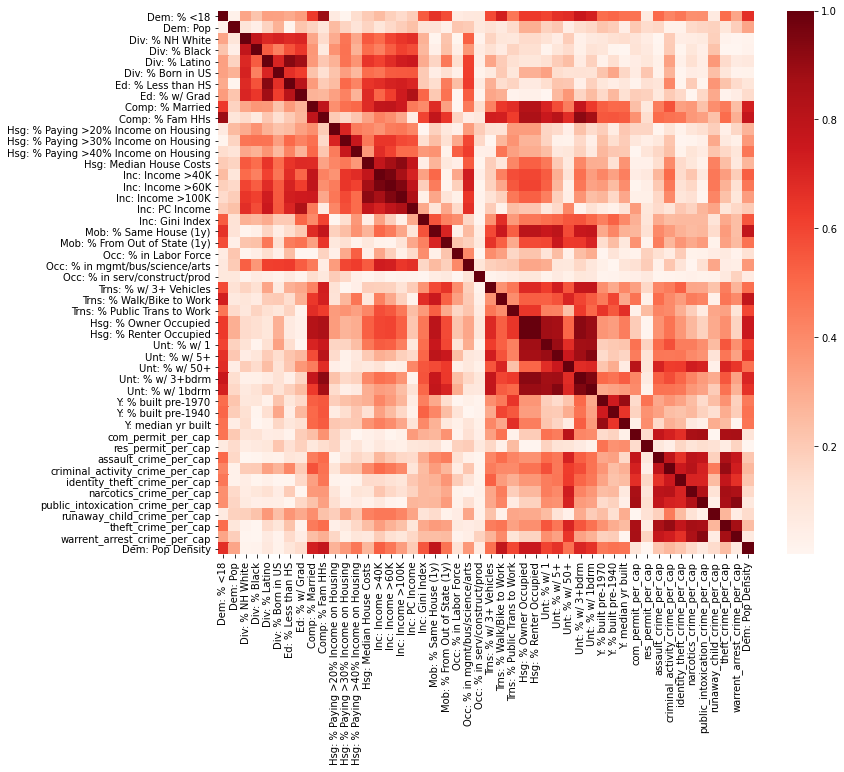

In [28]:
#Map full correlation matrix
plt.figure(figsize=(12,10))
cor = features_all.corr().abs()
sns.heatmap(cor, annot=False, cmap=plt.cm.Reds)
plt.show()

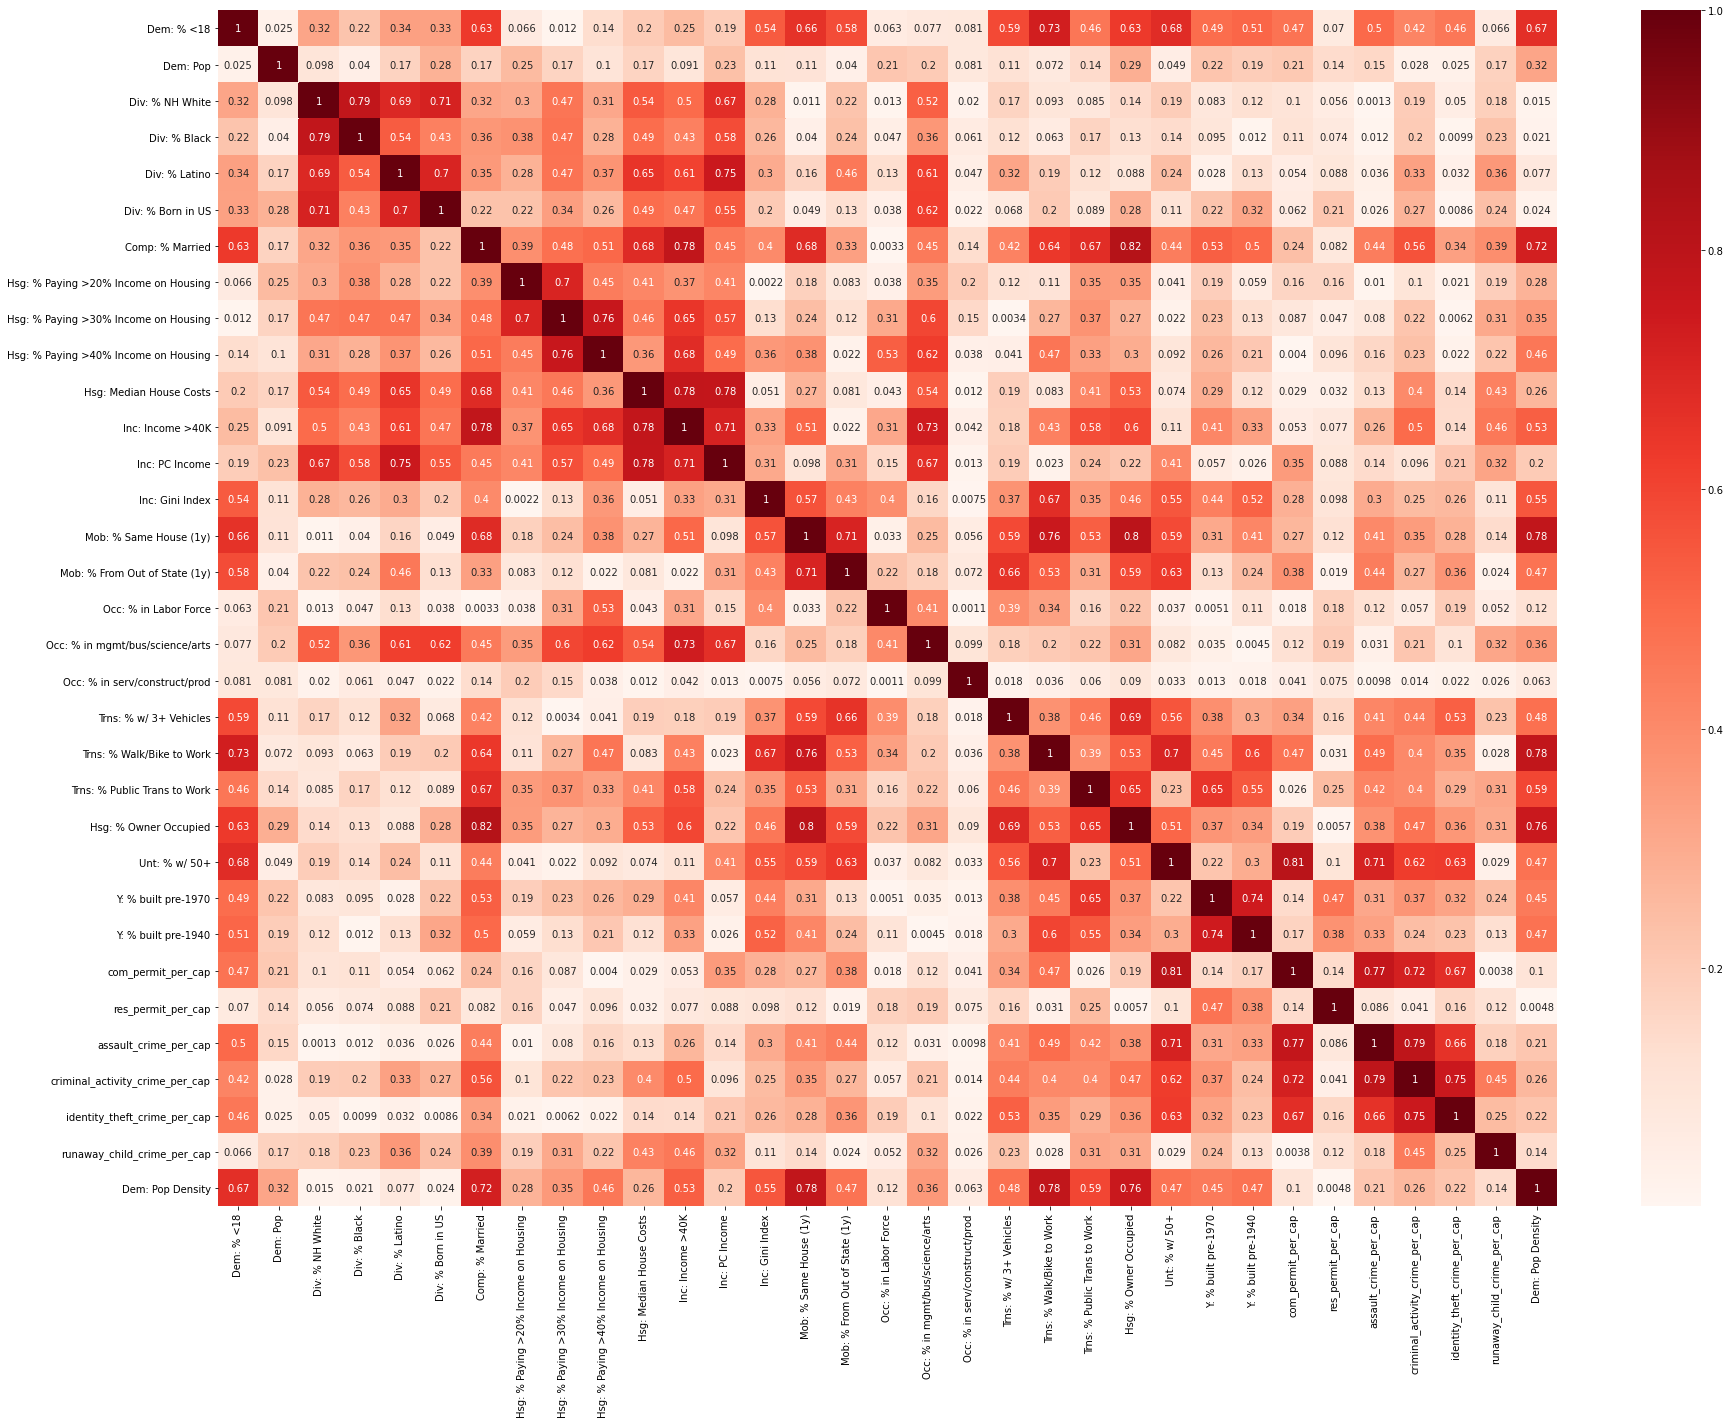

In [29]:
#Map medium correlation matrix
plt.figure(figsize=(30,22))
cor = features_m.corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

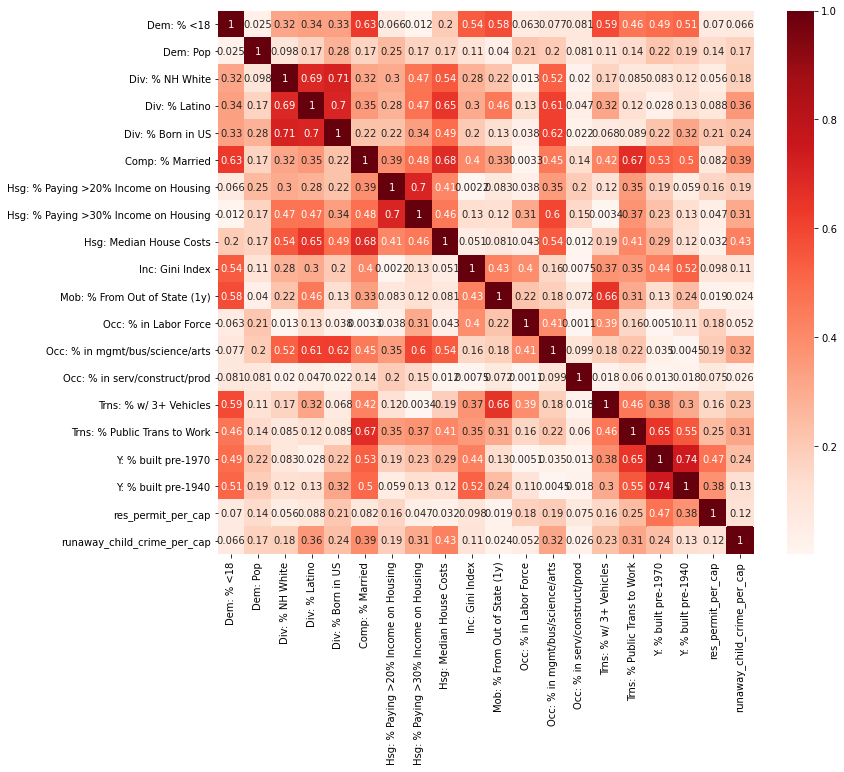

In [30]:
#Map small correlation matrix
plt.figure(figsize=(12,10))
cor = features_s.corr().abs()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## Write CSVs

In [45]:
features_s.to_csv("clean_data/features_s.csv")
features_m.to_csv("clean_data/features_m.csv")
features_all.to_csv("clean_data/features.csv")
outcomes.to_csv("clean_data/outcomes.csv")

In [50]:
df = df[df['year'] != 2019]
df.to_csv("clean_data/clean_full_dataset.csv")